In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_25/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.42135% 	8.75208% 	0.04888		0.04398		0.0		1.0	
(1024,256) 	95.4% 		0.52776% 	6.34099% 	0.82382		0.83219		3e-05		0.98864	
(1024,1024) 	3.04% 		1.89917% 	2.20077% 	0.02452		0.00225		0.0		0.50979	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 1.00000 1.00000 0.00000 	(213910, 0.9037879560274013) 0.91123 0.90379 0.00744 	(688427, 0.938751472320377) 0.00509 0.93875 0.93366 	
(32635, 1.0) 1.00000 1.00000 0.00000 	(212974, 0.8941978001127759) 0.90220 0.89420 0.00800 	(4240, 0.9623085983510011) 0.16509 0.96231 0.79722 	
(2436, 1.0) 0.76058 1.00000 0.23942 	(44828, 0.8401417658060423) 0.88693 0.84014 0.04679 	(694929, 0.9799764428739693) 0.00189 0.97998 0.97809 	
(55808, 1.0) 0.92141 1.00000 0.07859 	(232148, 0.8783613613364569) 0.89130 0.87836 0.01293 	(600540, 0.5747938751472321) 0.00178 0.57479 0.57302 	
(44159, 1.0) 0.99577 1.00000 0.00423 	(106790, 0.8420843224691953) 0.87690 0.84208 0.03482 	(226406, 0.8680800942285042) 0.04332 0.86808 0.82476 	
(25344, 1.0) 0.99995 1.00000 0.00005 	(155900, 0.8219974944514251) 0.84375 0.82200 0.02176 	(122896, 0.99528857

(2580, 1.0) 0.07957 1.00000 0.92043 	(81452, 0.9560840745164847) 0.91440 0.95608 0.04168 	(253066, 0.9646643109540636) 0.07633 0.96466 0.88833 	
(46219, 1.0) 0.99956 1.00000 0.00044 	(62612, 0.8908013524590833) 0.88264 0.89080 0.00817 	(146651, 0.9128386336866903) 0.04440 0.91284 0.86844 	
(58659, 1.0) 0.92829 1.00000 0.07171 	(118434, 0.9174479285497729) 0.87425 0.91745 0.04320 	(272646, 0.8138987043580682) 0.01152 0.81390 0.80238 	
(11156, 1.0) 0.99482 1.00000 0.00518 	(89238, 0.8931446765002358) 0.93368 0.89314 0.04054 	(483510, 0.9681978798586572) 0.02706 0.96820 0.94113 	
(8712, 1.0) 0.95757 1.00000 0.04243 	(222790, 0.8651861688749861) 0.89953 0.86519 0.03435 	(207996, 0.9316843345111897) 0.05602 0.93168 0.87566 	
(5655, 1.0) 0.17969 1.00000 0.82031 	(123902, 0.8427216030549833) 0.89073 0.84272 0.04801 	(465356, 1.0) 0.00219 1.00000 0.99781 	
(12302, 1.0) 0.99147 1.00000 0.00853 	(138808, 0.8876924220785591) 0.87016 0.88769 0.01753 	(101397, 0.8162544169611308) 0.18946 0.81625 0.

(6916, 1.0) 0.85653 1.00000 0.14347 	(75799, 0.8890604238321651) 0.88127 0.88906 0.00779 	(543746, 0.9976442873969376) 0.11552 0.99764 0.88212 	
(24845, 1.0) 0.93933 1.00000 0.06067 	(247431, 0.8492179722487541) 0.87548 0.84922 0.02626 	(492664, 1.0) 0.01795 1.00000 0.98205 	
(21376, 1.0) 1.00000 1.00000 0.00000 	(170669, 0.8415475770769518) 0.89328 0.84155 0.05173 	(437407, 0.014134275618374636) 0.01667 0.01413 0.00253 	
(10422, 1.0) 0.99997 1.00000 0.00003 	(200654, 0.8441286482530976) 0.86891 0.84413 0.02478 	(15552, 0.6595995288574794) 0.10240 0.65960 0.55720 	
(10025, 1.0) 0.99979 1.00000 0.00021 	(234027, 0.8607959383741) 0.88040 0.86080 0.01961 	(53249, 0.9882214369846879) 0.21179 0.98822 0.77643 	
(34299, 1.0) 1.00000 1.00000 0.00000 	(143533, 0.8744525904866949) 0.88649 0.87445 0.01203 	(250886, 0.9623085983510011) 0.13604 0.96231 0.82627 	
(17029, 1.0) 0.99744 1.00000 0.00256 	(224159, 0.9101678327236971) 0.89376 0.91017 0.01641 	(306230, 0.956419316843345) 0.06694 0.95642 0.

(49148, 1.0) 0.99998 1.00000 0.00002 	(20896, 0.8439391871763506) 0.86784 0.84394 0.02390 	(68623, 0.9976442873969376) 0.20733 0.99764 0.79031 	
(57861, 1.0) 1.00000 1.00000 0.00000 	(74555, 0.883654898393412) 0.87497 0.88365 0.00869 	(139664, 0.9646643109540636) 0.01683 0.96466 0.94783 	
(3502, 1.0) 0.07957 1.00000 0.92043 	(156980, 0.8936072949546993) 0.86334 0.89361 0.03027 	(3165, 0.96113074204947) 0.19072 0.96113 0.77041 	
(13518, 1.0) 0.99740 1.00000 0.00260 	(168684, 0.8775557081359189) 0.87911 0.87756 0.00156 	(144419, 0.9199057714958776) 0.11646 0.91991 0.80345 	
(67505, 1.0) 0.99999 1.00000 0.00001 	(88341, 0.9392154612222969) 0.86788 0.93922 0.07134 	(36871, 0.8315665488810364) 0.18102 0.83157 0.65055 	
(12037, 1.0) 0.90674 1.00000 0.09326 	(225500, 0.8809632279420466) 0.89580 0.88096 0.01483 	(213086, 0.35100117785630164) 0.09269 0.35100 0.25831 	
(61960, 1.0) 0.96810 1.00000 0.03190 	(83005, 0.8576520925643549) 0.89672 0.85765 0.03907 	(514545, 0.6466431095406361) 0.00711 

(259, 1.0) 0.43252 1.00000 0.56748 	(17314, 0.8490419367832586) 0.81880 0.84904 0.03024 	(264331, 0.7938751472320377) 0.09287 0.79388 0.70100 	
(23840, 1.0) 0.99998 1.00000 0.00002 	(110662, 0.8246079183182803) 0.90776 0.82461 0.08315 	(65695, 0.8621908127208481) 0.06653 0.86219 0.79566 	
(6412, 1.0) 0.75461 1.00000 0.24539 	(186516, 0.8439424305762835) 0.86529 0.84394 0.02135 	(241865, 0.8433451118963486) 0.05372 0.84335 0.78962 	
(55549, 1.0) 0.99462 1.00000 0.00538 	(204265, 0.8575250081535581) 0.86226 0.85753 0.00473 	(95592, 0.7891637220259129) 0.04625 0.78916 0.74291 	
(35761, 1.0) 0.97721 1.00000 0.02279 	(118222, 0.8354585627815965) 0.87850 0.83546 0.04304 	(193718, 0.8386336866902238) 0.05153 0.83863 0.78711 	
(120449, 1.0) 1.00000 1.00000 0.00000 	(158086, 0.8650159570861832) 0.87591 0.86502 0.01089 	(135704, 0.751472320376914) 0.03133 0.75147 0.72014 	
(7576, 1.0) 0.95669 1.00000 0.04331 	(238847, 0.8808678410505172) 0.87562 0.88087 0.00524 	(325689, 0.9340400471142521) 0.04

(64000, 1.0) 1.00000 1.00000 0.00000 	(178665, 0.8765360496630143) 0.88386 0.87654 0.00733 	(145465, 0.8445229681978799) 0.09757 0.84452 0.74696 	
(6033, 1.0) 0.11076 1.00000 0.88924 	(245587, 0.873195032251459) 0.89342 0.87320 0.02022 	(5297, 0.8386336866902238) 0.20057 0.83863 0.63806 	
(30592, 1.0) 1.00000 1.00000 0.00000 	(33632, 0.8021265610713691) 0.84251 0.80213 0.04038 	(97569, 0.9976442873969376) 0.04984 0.99764 0.94780 	
(6309, 1.0) 0.22368 1.00000 0.77632 	(75125, 0.7885187155025456) 0.86224 0.78852 0.07372 	(316949, 0.47703180212014135) 0.01305 0.47703 0.46398 	
(8571, 1.0) 0.99999 1.00000 0.00001 	(90140, 0.9166699544238075) 0.88237 0.91667 0.03430 	(194841, 0.9988221436984688) 0.07607 0.99882 0.92275 	
(84480, 1.0) 1.00000 1.00000 0.00000 	(247230, 0.8442600768531928) 0.87925 0.84426 0.03499 	(899882, 0.040047114252061256) 0.00002 0.04005 0.04002 	
(2442, 1.0) 0.35105 1.00000 0.64895 	(178764, 0.8500357172026176) 0.87782 0.85004 0.02779 	(439319, 0.8916372202591284) 0.042

(13819, 1.0) 1.00000 1.00000 0.00000 	(77619, 0.8696360964810543) 0.89015 0.86964 0.02051 	(93191, 0.96113074204947) 0.18102 0.96113 0.78011 	
(45333, 1.0) 1.00000 1.00000 0.00000 	(164382, 0.8224521256224923) 0.88073 0.82245 0.05828 	(320624, 0.9705535924617197) 0.02817 0.97055 0.94238 	
(29833, 1.0) 1.00000 1.00000 0.00000 	(184065, 0.8387689991771448) 0.85424 0.83877 0.01547 	(188764, 0.9988221436984688) 0.05148 0.99882 0.94734 	
(18304, 1.0) 1.00000 1.00000 0.00000 	(113782, 0.9629906982692393) 0.97866 0.96299 0.01567 	(68662, 1.0) 0.15965 1.00000 0.84035 	
(407, 1.0) 0.09544 1.00000 0.90456 	(111323, 0.8295898553029314) 0.89829 0.82959 0.06870 	(113223, 0.6442873969375736) 0.01287 0.64429 0.63141 	
(42558, 1.0) 0.99999 1.00000 0.00001 	(71211, 0.8650640283493213) 0.90576 0.86506 0.04070 	(32430, 0.8810365135453475) 0.02976 0.88104 0.85128 	
(49536, 1.0) 0.99870 1.00000 0.00130 	(42741, 0.8776156762329732) 0.90536 0.87762 0.02775 	(16393, 0.9481743227326267) 0.32208 0.94817 0.62609

(258, 1.0) 0.55771 1.00000 0.44229 	(32418, 0.7914176499394617) 0.84655 0.79142 0.05513 	(374080, 0.9269729093050648) 0.02389 0.92697 0.90308 	
(87300, 1.0) 1.00000 1.00000 0.00000 	(231712, 0.8740718142169187) 0.87447 0.87407 0.00040 	(181452, 0.6383981154299176) 0.06733 0.63840 0.57107 	
(1694, 1.0) 0.06557 1.00000 0.93443 	(28015, 0.8047441309420261) 0.80986 0.80474 0.00511 	(609111, 0.2096584216725559) 0.00087 0.20966 0.20879 	
(7261, 1.0) 1.00000 1.00000 0.00000 	(194768, 0.8829893599177296) 0.88524 0.88299 0.00225 	(546928, 1.0) 0.05471 1.00000 0.94529 	
(39812, 1.0) 1.00000 1.00000 0.00000 	(113550, 0.9360737343211221) 0.96182 0.93607 0.02575 	(581374, 0.9163722025912839) 0.00041 0.91637 0.91596 	
(20255, 1.0) 0.95509 1.00000 0.04491 	(250233, 0.9003757619497575) 0.90294 0.90038 0.00257 	(205973, 0.004711425206124825) 0.07032 0.00471 0.06560 	
(10109, 1.0) 1.00000 1.00000 0.00000 	(15573, 0.7999235713645879) 0.79805 0.79992 0.00187 	(247410, 0.20023557126030625) 0.00276 0.20024 

(2583, 1.0) 0.07957 1.00000 0.92043 	(64171, 0.8396305410400178) 0.87887 0.83963 0.03924 	(127740, 0.7997644287396938) 0.00075 0.79976 0.79902 	
(34820, 1.0) 0.99988 1.00000 0.00012 	(136491, 0.805306683379292) 0.86012 0.80531 0.05482 	(4432, 0.6042402826855124) 0.06517 0.60424 0.53907 	
(48673, 1.0) 0.99725 1.00000 0.00275 	(220217, 0.9182523903437212) 0.93295 0.91825 0.01470 	(434461, 0.9787985865724382) 0.02416 0.97880 0.95464 	
(77060, 1.0) 1.00000 1.00000 0.00000 	(26141, 0.7679243362332615) 0.81728 0.76792 0.04935 	(616142, 0.585394581861013) 0.00138 0.58539 0.58401 	
(13956, 1.0) 0.99996 1.00000 0.00004 	(228480, 0.8894898225344138) 0.88842 0.88949 0.00107 	(128246, 0.30388692579505305) 0.06228 0.30389 0.24161 	
(18688, 1.0) 1.00000 1.00000 0.00000 	(109440, 0.903100439181739) 0.88313 0.90310 0.01997 	(209996, 0.7538280329799765) 0.06619 0.75383 0.68764 	
(43909, 1.0) 0.68311 1.00000 0.31689 	(113210, 0.9572068406600707) 0.97624 0.95721 0.01904 	(34012, 0.9587750294464076) 0.087

(79490, 1.0) 1.00000 1.00000 0.00000 	(50662, 0.8554249535178949) 0.86886 0.85542 0.01344 	(782427, 0.729093050647821) 0.00195 0.72909 0.72715 	
(52093, 1.0) 1.00000 1.00000 0.00000 	(40665, 0.8303064874773928) 0.86226 0.83031 0.03195 	(40551, 0.994110718492344) 0.04077 0.99411 0.95334 	
(41605, 1.0) 0.99990 1.00000 0.00010 	(15991, 0.7502294134136096) 0.73531 0.75023 0.01492 	(364782, 0.9340400471142521) 0.03278 0.93404 0.90126 	
(118785, 1.0) 1.00000 1.00000 0.00000 	(146150, 0.9266525030647813) 0.90212 0.92665 0.02453 	(75863, 1.0) 0.14110 1.00000 0.85890 	
(73603, 1.0) 1.00000 1.00000 0.00000 	(113304, 0.9090150949789253) 0.95954 0.90902 0.05052 	(591380, 0.8433451118963486) 0.01523 0.84335 0.82811 	
(30491, 1.0) 1.00000 1.00000 0.00000 	(94499, 0.8784966642290912) 0.87060 0.87850 0.00790 	(599687, 0.7526501766784454) 0.00248 0.75265 0.75017 	
(22432, 1.0) 0.97608 1.00000 0.02392 	(129534, 0.8679993585768148) 0.88134 0.86800 0.01334 	(13573, 0.9375736160188458) 0.11930 0.93757 0.81

(4734, 1.0) 0.98950 1.00000 0.01050 	(248212, 0.8920951409612782) 0.89725 0.89210 0.00516 	(47284, 0.9705535924617197) 0.05756 0.97055 0.91299 	
(782, 1.0) 0.68997 1.00000 0.31003 	(18875, 0.8250735102522675) 0.83566 0.82507 0.01058 	(187495, 0.9658421672555949) 0.06773 0.96584 0.89811 	
(34691, 1.0) 0.99938 1.00000 0.00062 	(218304, 0.8976529894208028) 0.91839 0.89765 0.02074 	(303381, 0.9340400471142521) 0.02202 0.93404 0.91202 	
(3992, 1.0) 0.07957 1.00000 0.92043 	(119875, 0.9199930085638324) 0.87417 0.91999 0.04582 	(396459, 0.9281507656065962) 0.09359 0.92815 0.83456 	
(2309, 1.0) 0.66351 1.00000 0.33649 	(148817, 0.9478052731636244) 0.93737 0.94781 0.01044 	(167021, 0.8928150765606597) 0.09988 0.89282 0.79293 	
(26498, 1.0) 0.98349 1.00000 0.01651 	(235806, 0.8849620453710408) 0.88581 0.88496 0.00085 	(563505, 0.13898704358068323) 0.00662 0.13899 0.13237 	
(13069, 1.0) 0.99858 1.00000 0.00142 	(117156, 0.8414725698011379) 0.85994 0.84147 0.01847 	(331787, 0.8280329799764429) 0.1

(36871, 1.0) 0.88006 1.00000 0.11994 	(197458, 0.861925474390487) 0.84806 0.86193 0.01387 	(387073, 0.8987043580683157) 0.07926 0.89870 0.81945 	
(25728, 1.0) 1.00000 1.00000 0.00000 	(245917, 0.8600150739744425) 0.88510 0.86002 0.02509 	(536083, 1.0) 0.05020 1.00000 0.94980 	
(14466, 1.0) 0.99834 1.00000 0.00166 	(259049, 0.8571697186970271) 0.85855 0.85717 0.00138 	(322605, 0.9988221436984688) 0.07403 0.99882 0.92479 	
(50687, 1.0) 1.00000 1.00000 0.00000 	(102644, 0.8670731648160006) 0.85717 0.86707 0.00991 	(211733, 0.8374558303886925) 0.00722 0.83746 0.83023 	
(29449, 1.0) 1.00000 1.00000 0.00000 	(210917, 0.8635339776019665) 0.88324 0.86353 0.01970 	(269381, 0.9316843345111897) 0.10294 0.93168 0.82875 	
(14592, 1.0) 1.00000 1.00000 0.00000 	(218052, 0.8966434191487266) 0.91376 0.89664 0.01712 	(441413, 1.0) 0.13377 1.00000 0.86623 	
(96386, 1.0) 0.59775 1.00000 0.40225 	(183675, 0.8595527157205531) 0.85122 0.85955 0.00833 	(124108, 0.9316843345111897) 0.05183 0.93168 0.87986 	
(4

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


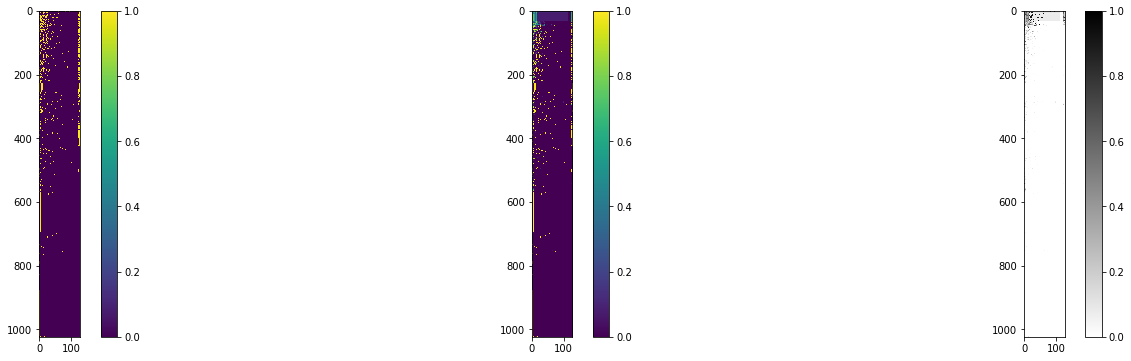

3.4765293e-05
0.9886369


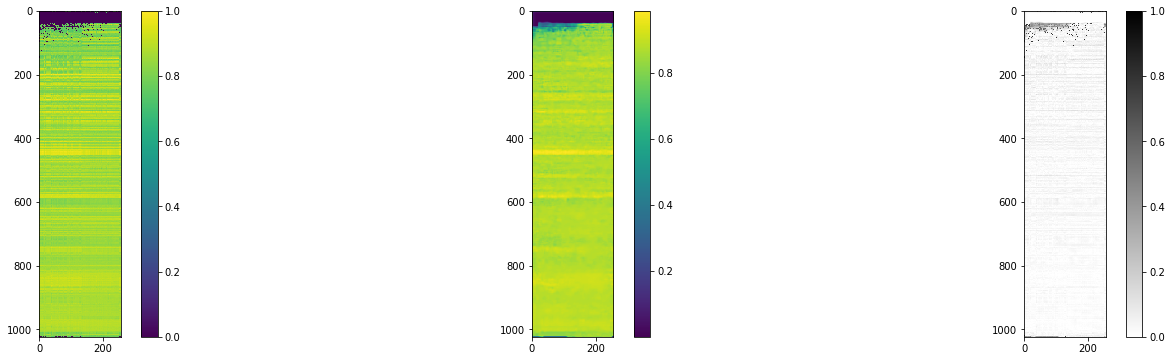

1.1183923e-16
0.5097897


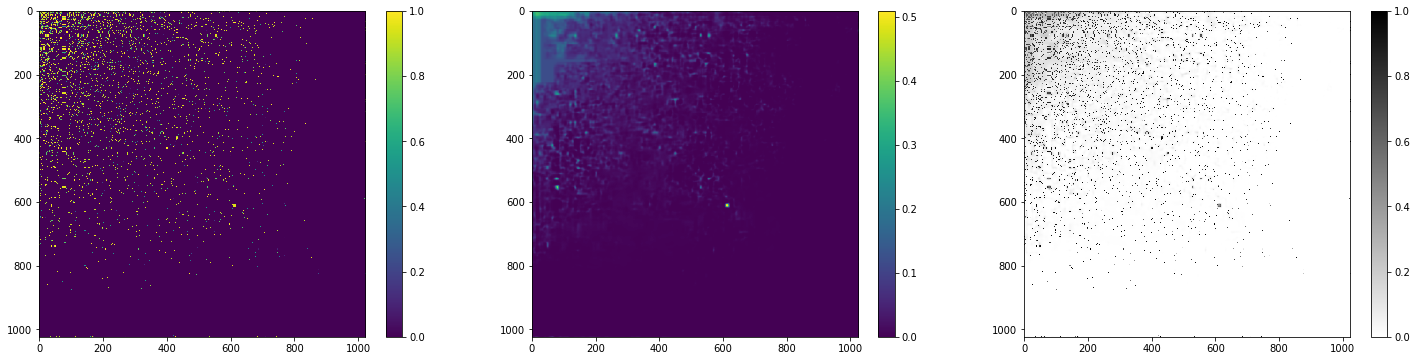

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_50/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


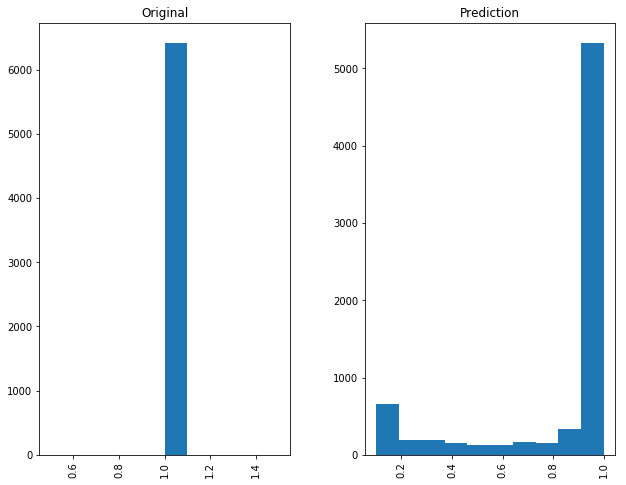

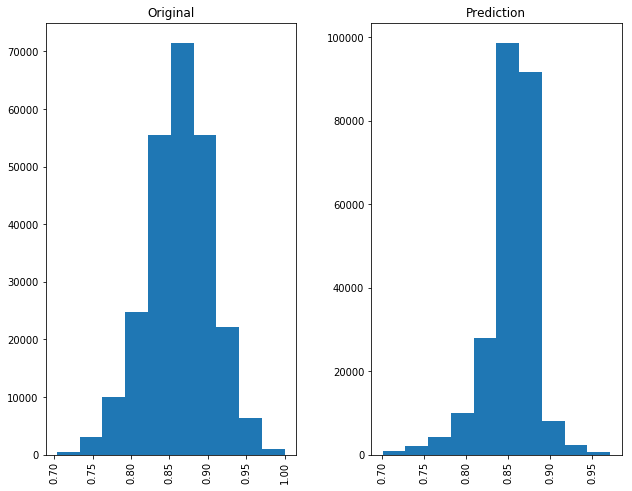

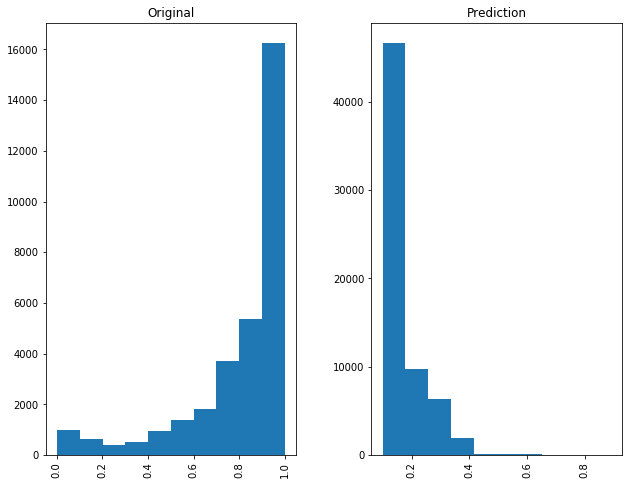

In [7]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'histogram_distribution_' + str(i))
    

/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


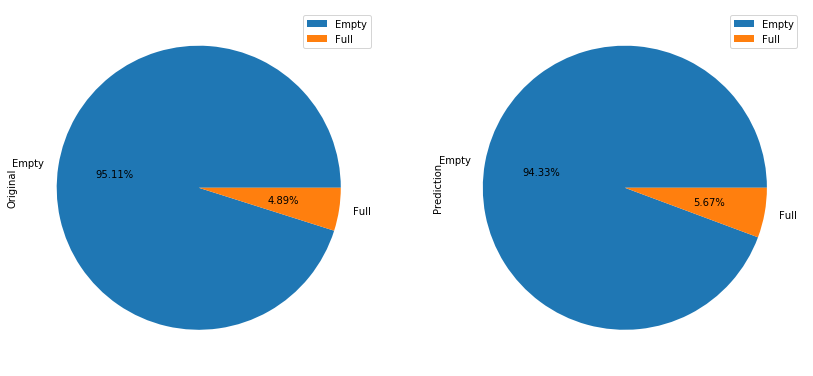

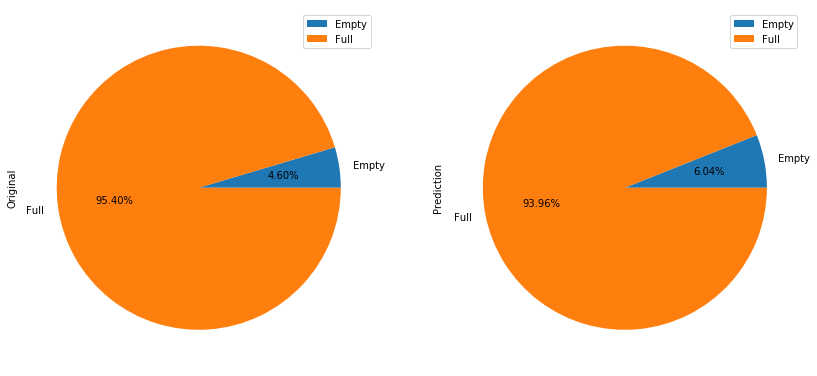

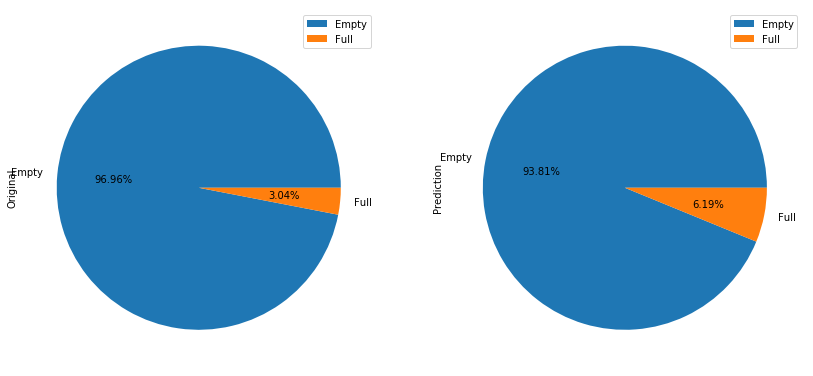

In [8]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['Original'] = []
    d['Original'].append(len(org_data[org_data == 0]) / length)
    d['Original'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['Prediction'] = []
        d['Prediction'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['Prediction'].append(len(pred_data[pred_data > 0.1]) / length)

    fig, ax = plt.subplots(figsize=(14,8))
    df = pd.DataFrame(d, index=['Empty', 'Full'])
    df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f%%', ax=ax)
    fig.savefig(path + 'pie_density_' + str(i))

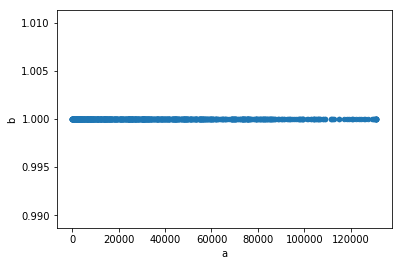

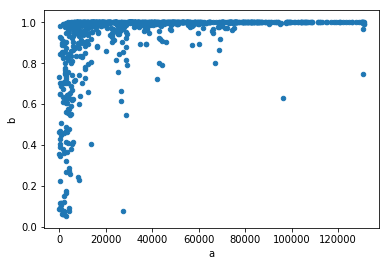

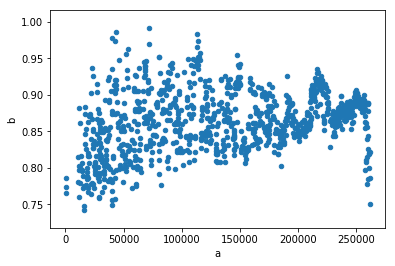

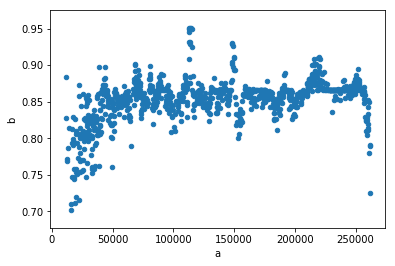

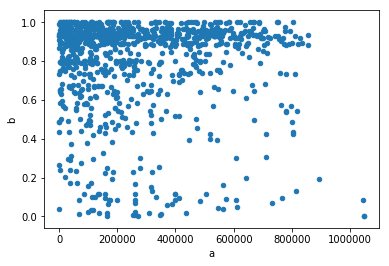

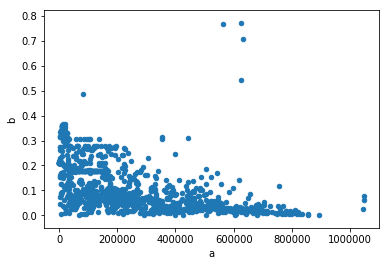

In [9]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    df = pd.DataFrame(new_predict_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    new_predict_data

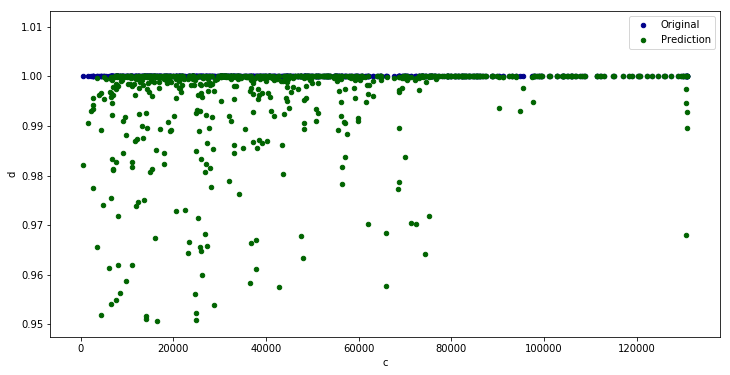

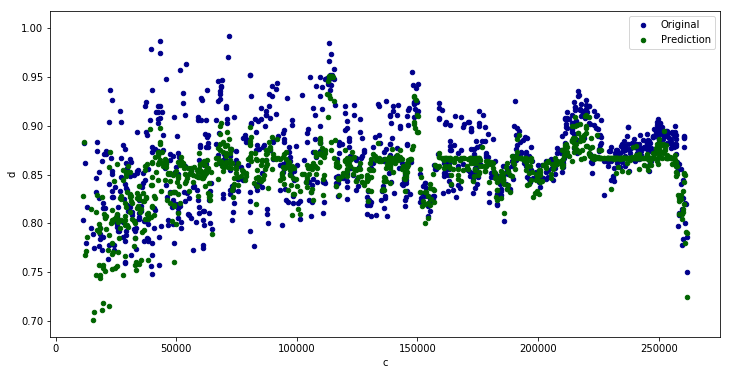

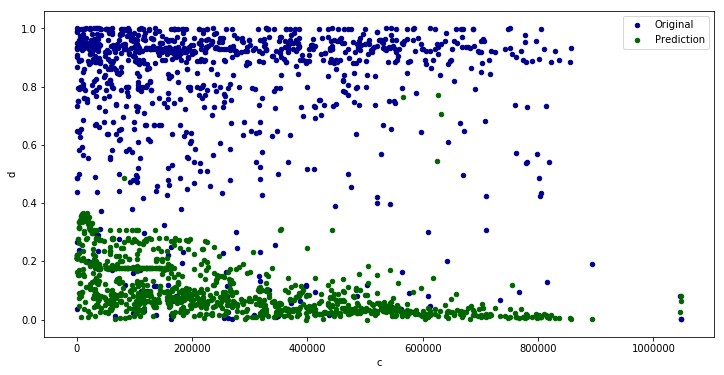

In [10]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
    df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));

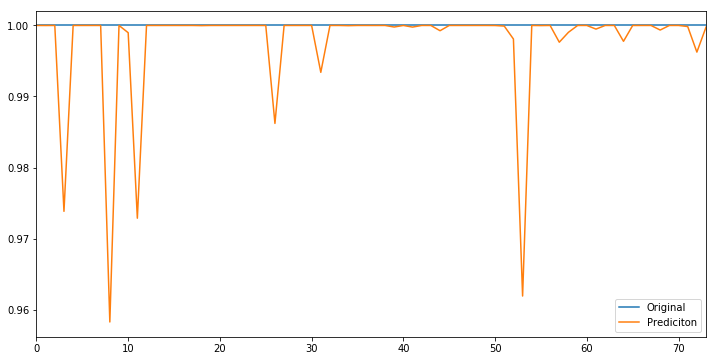

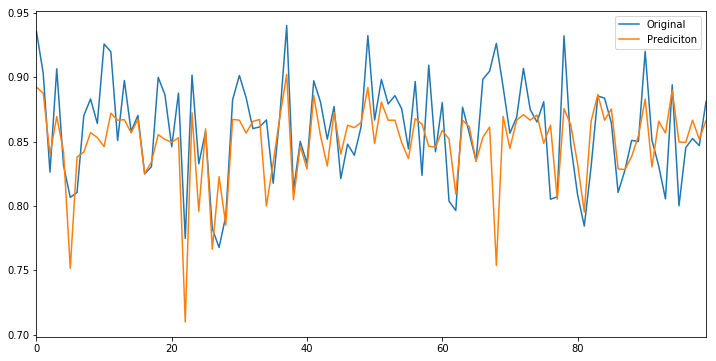

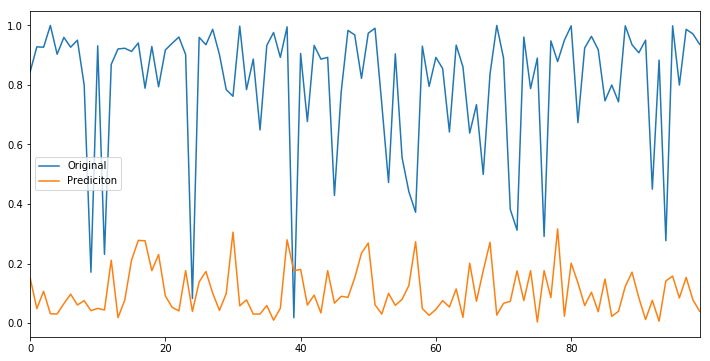

In [11]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][1], predict_data[j][1]])
        else:
            data.append([org_data[j][1], predict_data[j][1]])

    fig, ax = plt.subplots(figsize=(12,6))
    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    df.plot(subplots=False, figsize=(12,6), ax=ax)
    fig.savefig(path + 'graph_org_vs_prediction_' + str(i))